In [1]:
import random
import numpy as np
import math
from copy import deepcopy
import tensorflow as tf
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

In [2]:
#@title codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


# Lecture Codes

In [3]:
class SlipperyWindyCliffGridWorld:
    def __init__(self, grid=None, wind=None, slip_prob=None):
        self.grid = grid or [
            ['C', 'C', 'C', 'C', 'C', 'C', 'C'],
            ['.', '.', '.', '.', '.', '.', 'C'],
            ['.', 'G', '.', '.', '.', '.', 'C'],
            ['.', 'T', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', 'T', '.'],
            ['.', '.', '.', '.', '.', 'S', '.'],
            ['.', '.', '.', '.', '.', '.', '.'],
            ['C', 'C', 'C', 'C', 'C', 'C', 'C']
        ]
        self.max_row = len(self.grid) - 1
        self.max_col = len(self.grid[0]) - 1
        self.initial_pos = next(
            [row_index, col_index] for row_index, row in enumerate(self.grid) \
            for col_index, cell in enumerate(row) if cell == 'S'
        )
        self.goal = next(
            [row_index, col_index] for row_index, row in enumerate(self.grid) \
            for col_index, cell in enumerate(row) if cell == 'G'
        )
        self.terminal = list(
            [row_index, col_index] for row_index, row in enumerate(self.grid) \
            for col_index, cell in enumerate(row) if (cell == 'G') or (cell == 'C')
        )
        if wind is None:
            self.wind = [0 for _ in range(self.max_col+1)]    # All zeros
        else:
            self.wind = [i%2 for i in range(self.max_col+1)]  # Wind strength at each column

        self.slip_prob = slip_prob or 0.1  # Probability of slipping (not taking intended action)
        self.reset()

    def reset(self, random=True):
        # Use exploring starts by default
        self.is_done = False
        if random:
            while True:
                self.cur_state = [np.random.randint(self.max_row + 1), np.random.randint(self.max_col + 1)]
                if self.cur_state not in [self.terminal]:
                    break
        else:
            self.cur_state = deepcopy(self.initial_pos)
        return self.cur_state

    def _get_state_dim(self):
        return np.array(self.grid).shape

    def _get_action_dim(self):
        return np.array([4])

    def transition(self, state, action):
        if self.is_done:
            return 0, state, True

        next_state = deepcopy(state)

        # Slippery part
        if np.random.rand() < self.slip_prob:
            action = np.random.choice(4)

        if action == 0:
            next_state[1] += 1   # right
        elif action == 1:
            next_state[0] += 1   # down
        elif action == 2:
            next_state[1] -= 1   # left
        elif action == 3:
            next_state[0] -= 1   # up
        next_state = np.clip(next_state, [0, 0], [self.max_row, self.max_col]).tolist()

        # Windy part
        next_state[0] -= self.wind[next_state[1]]
        next_state[0] = max(0, next_state[0])

        row, col = next_state
        if self.grid[row][col] == 'G':
            reward = 100   # goal
            self.is_done = True
        elif self.grid[row][col] == 'C':
            reward = -200  # cliff
            self.is_done = True
        elif self.grid[row][col] == 'T':
            reward = -50   # trap
        else:
            reward = -1
            self.is_done = False

        return reward, next_state, self.is_done

In [4]:
class TemporalDifference:
    def __init__(self, Env, alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9):
        self.Env = Env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd

        self.state_dim = self.Env._get_state_dim()[0]
        self.action_dim = self.Env._get_action_dim()
        self.V = np.zeros(self.state_dim)
        self.Q = np.zeros((self.state_dim, self.action_dim))
        self.E = np.zeros((*self.state_dim, self.action_dim))

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            return np.argmax(self.Q[state[0], state[1], :])

    def train(self, num_episodes, on_policy=True):
        for _ in tqdm(range(num_episodes)):
            episode_memory = []  # to be used when lambd=1
            self.E *= 0
            state = self.Env.reset()
            action = self.epsilon_greedy_policy(state)

            while not self.Env.is_done:
                reward, next_state, done = self.Env.transition(state, action)
                next_action = self.epsilon_greedy_policy(next_state)

                if self.lambd == 1:
                    episode_memory.append((state, action, reward))
                    state, action = next_state, next_action
                    continue

                if on_policy:
                    delta = reward + self.gamma * (
                        self.Q[next_state[0], next_state[1], next_action] - self.Q[state[0], state[1], action]
                    )
                else:
                    best_next_action = np.argmax(self.Q[next_state[0], next_state[1], :])
                    delta = reward + self.gamma * (
                        self.Q[next_state[0], next_state[1], best_next_action] - self.Q[state[0], state[1], action]
                    )

                self.E[state[0], state[1], action] += 1
                self.Q += self.alpha * delta * self.E
                self.E *= self.gamma * self.lambd

                state, action = next_state, next_action

            if self.lambd == 1:
                G = 0
                for state, action, reward in reversed(episode_memory):
                    G = reward + self.gamma * G
                    self.Q[state[0], state[1], action] += self.alpha * (G - self.Q[state[0], state[1], action])

# Q1: Continuous Grid World Environment

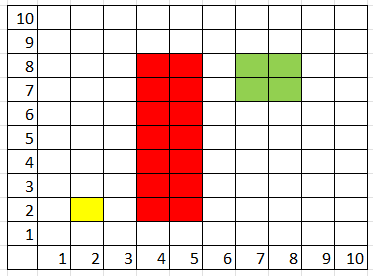

The ContinuousGridWorld class defines an environment for a grid world in which an agent can move continuously in 2D space. The agent's goal is to navigate from its starting position to one of the goal locations while avoiding trap regions.

The environment's grid is represented by a 2D array, and the agent's position is defined by its coordinates (x, y), with a starting point at [2,2]. The agent can move in 36 different directions (36 actions) for 360 degree movement, with each action corresponding to a 10-degree change in angle.

During a transition, the agent's new position is calculated based on the action taken, and rewards are assigned according to the agent's location relative to the goal and trap regions. If the agent reaches the goal, it receives a reward of 100, and if it steps on a trap, it receives a penalty of -50. Otherwise, the agent receives a reward of -1 for each step taken. The environment also handles episode termination when the agent reaches the goal.

Additionally, the environment allows for random initialization, exploration starting from a random position, and provides methods to access the state and action space dimensions. Overall, the environment provides a continuous grid world for agents to navigate with various rewards and obstacles.

In [53]:
class ContinuousGridWorld:
    """
    Initialize the ContinuousGridWorld environment.

    Args:
        grid (undefined): A grid representing the environment layout.
        wind (undefined): Wind parameters affecting the agent's movement.
        slip_prob (undefined): Probability of slipping during movement.
        verbose (bool, optional): Whether to print verbose information.
    """
    def __init__(self, grid=None, wind=None, slip_prob=None, verbose=False):
        self.verbose = verbose
        self.max_row = 10
        self.max_col = 10
        self.initial_pos = [2, 2]  # Starting position (row, col)
        self.goal = self.terminal = [[7, 7], [7, 8], [8, 7], [8, 8]]
        self.trap = [[2, 4], [2, 5], [8, 4], [8, 5]]
        self.reset()

    def is_in_region(self, region, xy_point):
        """
        Check if a given point is within a specified region.

        Args:
            region: A list of coordinates defining the region.
            xy_point: The point to check (x, y).

        Returns:
            bool: True if the point is in the region, False otherwise.
        """
        # Check if the random coordinate is within the rectangle
        x, y = xy_point
        x_min, y_min = min(point[0] for point in region), min(point[1] for point in region)
        x_max, y_max = max(point[0] for point in region), max(point[1] for point in region)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            return True
        else:
            return False

    def move(self, cur_position, angle):
        """
        Move the agent's position based on the specified angle.

        Args:
            cur_position: Current position of the agent (x, y).
            angle: The angle in degrees divided by 10

        Returns:
            list: The new position of the agent (x, y).
        """
        # Current position
        x, y = cur_position[0], cur_position[1]

        # Convert degrees to radians
        angle_in_rad = math.radians((angle+1)*10)

        # Calculate the change in x and y coordinates based on the current angle
        delta_x = math.cos(angle_in_rad)
        delta_y = math.sin(angle_in_rad)

        # Update the agent's position
        x += delta_x
        y += delta_y

        # Clip new position to defined boundaries
        x = np.clip(x, 0, self.max_row)
        y = np.clip(y, 0, self.max_col)

        return [round(x, 1), round(y, 1)]

    def reset(self, random=False):
        """
        Reset the environment to its initial state.

        Args:
            random (bool, optional): If True, reset to a random state.

        Returns:
            list: The initial or random state (x, y).
        """
        # Use exploring starts by default
        self.is_done = False
        if random:
            while True:
                self.cur_state = [np.random.randint(self.max_row + 1), np.random.randint(self.max_col + 1)]
                if self.cur_state not in [self.terminal]:
                    break
        else:
            self.cur_state = deepcopy(self.initial_pos)
        return self.cur_state

    def _get_state_dim(self):
        """
        Get the dimensions of the state space.

        Returns:
            list: The dimensions of the state space
        """
        return [10, 10]

    def _get_action_dim(self):
        """
        Get the dimensionality of the action space.

        Returns:
            int: The number of possible actions, which is 36.
        """
        return 36 # 36 possible actions (10 degrees per action)

    def transition(self, state, action):
        """
        Perform a transition based on the given state and action.

        Args:
            state: The current state (x, y).
            action: The action to take.

        Returns:
            tuple: A tuple containing the reward, next state, and a flag indicating if the episode is done.
        """
        if self.is_done:
            return 0, state, True

        current_state = deepcopy(state)
        next_state = self.move(current_state, action)

        if self.is_in_region(self.goal, next_state):
            reward = 100   # goal
            if self.verbose: print(f"Reached goal, rewards: {reward}, state: {next_state}")
            self.is_done = True
        elif self.is_in_region(self.trap, next_state):
            reward = -50   # trap
            if self.verbose: print(f"stepped on trap, rewards: {reward}, state: {next_state}")
        else:
            reward = -1    # normal step
            self.is_done = False
            if self.verbose: print(f"rewards: {reward}, state: {next_state}")

        return reward, next_state, self.is_done

# Agent

# Q Network - Function Approximator

These codes define an agent using TD learning with a function approximation method. It consists of two main parts: the QNetwork class for approximating Q-values and the TemporalDifference class for training the agent.

In the QNetwork class, a neural network is defined with fully connected layers to approximate Q-values. The forward method computes Q-values for a given state using a series of fully connected layers with Relu activations.

The TemporalDifference class initializes an agent with hyperparameters such as learning rate, discount factor, exploration rate, and eligibility trace parameters. It creates a Q-network using the QNetwork class, sets up an optimizer for weight updates, and defines a mean squared error loss function for backpropagation. The agent can choose actions based on the epsilon-greedy strategy or Q values, and it can be trained over a specified number of episodes using either on-policy or off-policy learning methods. The train method updates the Q-network using TD learning and eligibility traces, which involves forward and backward passes in the neural network. If lambd is 1, it computes the returns and updates the Q-values based on the complete episode history.

In [87]:
# Define the neural network for Q-value approximation
class QNetwork(nn.Module):
    """
    Neural network for Q-value approximation.

    Args:
        state_dim (int): Dimensionality of the state space.
        action_dim (int): Dimensionality of the action space.
    """
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Define fully connected layers for the neural network
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, action_dim)

    def forward(self, x):
        """
        Forward pass of the QNetwork.

        Args:
            x: Input state.

        Returns:
            x: Q-values for the given state.
        """
        # Perform a series of fully connected layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class TemporalDifference:
    """
    Temporal Difference learning agent.

    Args:
        Env: The environment.
        alpha (float, optional): Learning rate.
        gamma (float, optional): Discount factor.
        epsilon (float, optional): Exploration rate.
        lambd (float, optional): Lambda parameter for eligibility traces.
        verbose (bool, optional): Whether to print verbose information.
    """
    def __init__(self, Env, alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9, verbose=False):
        self.Env = Env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd
        # Get the dimensionality of the state and action space
        self.state_dim = self.Env._get_state_dim()
        self.action_dim = self.Env._get_action_dim()
        # Create the Q-network for Q-value approximation
        self.Q_network = QNetwork(len(self.state_dim), self.action_dim)
        # Optimizer for updating weights
        self.optimizer = optim.Adam(self.Q_network.parameters(), lr=self.alpha)
        # Loss function for backpropagation
        self.loss_fn = nn.MSELoss()
        # Initialize eligibility traces
        self.E = torch.zeros(1, self.action_dim)

    def choose_action(self, state):
        """
        Choose an action based on the current state.

        Args:
            state: The current state.

        Returns:
            action: The selected action.
        """
        # Convert the state to a tensor
        state_tensor = torch.tensor(state, dtype=torch.float32)
        # Get Q-values from the Q-network
        q_values = self.Q_network(state_tensor)
         # Choose an action with epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = q_values.argmax().item()
        return action

    def train(self, num_episodes, on_policy=True, loop_iter_limit=5000):
        """
        Train the agent using temporal difference learning with a function approximator network.

        Args:
            num_episodes (int): The number of episodes to train.
            on_policy (bool, optional): Whether to use on-policy learning.
            loop_iter_limit (int): End the while loop after the specified number of iterations
        """

        for _ in tqdm(range(num_episodes)):
            # Reset the environment and choose an initial action
            state = self.Env.reset()
            action = self.choose_action(state)
            rewards = []
            iter = 0

            if self.lambd == 1:
                # Initialize episode memory for lambd = 1
                episode_memory = []

            while not self.Env.is_done:
                # Take a step in the environment and observe the next state and reward
                reward, next_state, done = self.Env.transition(state, action)
                # Choose the next action based on the next state
                next_action = self.choose_action(next_state)
                rewards.append(reward)

                # Teriminate the loop if the tthreshold is reached
                if iter > loop_iter_limit:
                    #print(f"Terminating after {loop_iter_limit} iterations.")
                    break
                else:
                    iter += 1

                if self.lambd == 1:
                    # Store state, action, and reward
                    episode_memory.append((state, action, reward))
                    state, action = next_state, next_action
                    continue

                if on_policy:
                    # Compute the temporal difference error for on-policy learning
                    state_tensor = torch.tensor(state, dtype=torch.float32)
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                    q_values = self.Q_network(state_tensor)
                    next_q_values = self.Q_network(next_state_tensor)
                    delta = reward + self.gamma * (next_q_values[next_action] - q_values[action])

                else:
                    # Compute the temporal difference error for off-policy learning
                    state_tensor = torch.tensor(state, dtype=torch.float32)
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                    q_values = self.Q_network(state_tensor)
                    next_q_values = self.Q_network(next_state_tensor)
                    best_next_action = next_q_values.argmax()
                    delta = reward + self.gamma * (next_q_values[best_next_action] - q_values[action])

                # Update eligibility traces
                self.E *= self.gamma * self.lambd
                self.E[0, action] += 1
                # Perform backpropagation and update the Q-network
                self.optimizer.zero_grad()
                # Prediction value
                pred_val = self.Q_network.forward(torch.tensor(state, dtype=torch.float32))
                # True value
                true_val = torch.tensor(self.alpha * delta * self.E).detach().numpy()
                # Compute loss, propagate gradients, and update network
                loss = self.loss_fn(torch.tensor(pred_val, requires_grad=True), torch.tensor(true_val, requires_grad=True))
                loss.backward()
                self.optimizer.step()
                # Transition to the next state and choose the next action
                state, action = next_state, next_action

            # If lambd is 1, perform retrospective updates using episode memory
            if self.lambd == 1:
                G = 0
                for state, action, reward in reversed(episode_memory):
                    G = reward + self.gamma * G
                    state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=True)
                    q_values = self.Q_network(state_tensor)
                    delta = G - q_values[action]
                    self.optimizer.zero_grad()
                    # Prediction value
                    pred_val = self.Q_network.forward(torch.tensor(state, dtype=torch.float32))
                    # True value
                    true_val = torch.tensor(self.alpha * delta * self.E).detach().numpy()
                    # Compute loss, propagate gradients, and update network
                    loss = self.loss_fn(torch.tensor(pred_val, requires_grad=True), torch.tensor(true_val, requires_grad=True))
                    loss.backward()
                    self.optimizer.step()


def test_agent(agent, env, num_episodes=1, verbose=False, loop_iter_limit=500):
    """
    Test an agent in an environment by running episodes and calculating the average reward.

    Args:
        agent: The agent to be tested.
        num_episodes (int, optional): Number of episodes to run
        loop_iter_limit (int): End the while loop after the specified number of iterations
    """
    rewards = []
    i = 0
    iter = 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        if verbose: print("state: ", state)
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            #q_values = agent.Q_network(state_tensor)
            # Choose an action based on the Q values
            #action = q_values.argmax().item()
            action = agent.Q_network.forward(state_tensor).argmax().item()
            reward, next_state, done = env.transition(state, action)
            if verbose and (i % 50==0 or i in np.arange(10)):
                print(f"Iteration: {i}, reward: {reward}, next_state {next_state}, done: {done}, action: {action}")
            i += 1
            episode_reward += reward
            state = next_state

            # Teriminate the loop if the tthreshold is reached
            if iter > loop_iter_limit:
                break
            else:
                iter += 1

        rewards.append(episode_reward)

    avg_reward = sum(rewards) / num_episodes
    print(f"Average reward over {num_episodes} episodes: {avg_reward}")

In [88]:
env = ContinuousGridWorld()
agent0 = TemporalDifference(env, alpha=0.01, gamma=0.9, epsilon=0.1, lambd=0.9, verbose=False)
agent0.train(num_episodes=100, loop_iter_limit=5000, on_policy=True)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-87-332e8c856d18>:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_val = torch.tensor(self.alpha * delta * self.E).detach().numpy()
<ipython-input-87-332e8c856d18>:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(pred_val, requires_grad=True), torch.tensor(true_val, requires_grad=True))
100%|██████████| 100/100 [00:01<00:00, 50.74it/s]


In [89]:
test_agent(agent=agent0, env=env, num_episodes=1, verbose=True, loop_iter_limit=500)

state:  [2, 2]
Iteration: 0, reward: -1, next_state [2.2, 3.0], done: False, action: 7
Iteration: 1, reward: -50, next_state [2.4, 4.0], done: False, action: 7
Iteration: 2, reward: -50, next_state [2.6, 5.0], done: False, action: 7
Iteration: 3, reward: -1, next_state [2.8, 6.0], done: False, action: 7
Iteration: 4, reward: -1, next_state [3.0, 7.0], done: False, action: 7
Iteration: 5, reward: -1, next_state [4.0, 7.0], done: False, action: 35
Iteration: 6, reward: -1, next_state [5.0, 7.0], done: False, action: 35
Iteration: 7, reward: -1, next_state [6.0, 7.0], done: False, action: 35
Iteration: 8, reward: 100, next_state [7.0, 7.0], done: True, action: 35
Average reward over 1 episodes: -6.0


## Results and Discussion



The ContinuousGridWorld and TemporalDifference classes provide an environment and agent for the defined problem. The current model based on agent that is trained with a function approximator for a Q network appears to perform suboptimally and is not able to converge to a desired policy most of the time. The policy in most cases appears to stagnant on one or two actions, thus fails to reach the target location, possibly due to insufficient training or non-stringent constraints.

Future improvements can include enhancing the ContinuousGridWorld environment by making it more customizable with user-defined grid layouts, wind patterns, and variable slip probabilities. Additionally, adding dynamic elements to the environment, such as moving obstacles or changing goal positions, would increase its complexity. For the TemporalDifference agent, improving its performance can be achieved by experimenting with different neural network architectures, hyperparameters, and training strategies. Furthermore, implementing advanced exploration strategies like epsilon-decay or more sophisticated policies could lead to more efficient learning. The results obtained from these classes would depend on the specific configurations, environments, and tasks used. By fine-tuning the parameters and allowing for more complex scenarios, the agent's ability to learn and adapt to diverse environments can be greatly improved.

# BlackJack

Overview:
*  Deck: Ace, 2-10, Jack and Queen
*  Objective: Maximize winnings or minimize losses

Env:
*   Ace: {1, 11}, Jack or Queen = 10, else = face value
*   Win if total = 21 on the first 2 cards = blackjack
*   Tie if dealer also has blackjack
*   Win payout = +1, blackjack payout = +1.5, tie = 0
*   Player is dealt two cards, action = {"hit", "stand"}
*   Card total > 21 = busts (loses)
*   Dealer has 1 face up card and draw iff hard 16, soft 17 or lower

Agents:
*   Q Learning
*   Monte Carlo


# Environment

The provided code defines a Python class called BlackjackEnvironment that simulates a simplified game of Blackjack. The class initializes the game environment with a deck of cards, assigns values to each card in the deck, and offers methods for simulating the game.

The deal_card method simulates drawing a card from the deck, and the card_mapper method maps card values to their corresponding numeric values.

The initial_state method initializes the game state, generating the two player cards and one face up dealer card. The player can choose to "hit" (draw a card) or "stand" (end their turn) using the player_action method.

The hand_total methods calculate the total value of a hand, considering possible values for Aces. The dealer_action method determines the dealer's action based on their hand, adhering to typical Blackjack rules. The accepted_value method helps identify acceptable values for the player and dealer, ensuring values do not exceed 21.

The step method simulates a single step in the game, updating player and dealer hands, calculating rewards, and determining if the game is over. The play method simulates an entire game and returns the final reward.



## The following assumptions were implemented in the environment and state-transition.

- Deck Composition: The deck is modified to exclude Kings, leaving only Ace, 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack, and Queen.
  - The provided code defines a Python class called BlackjackEnvironment, which simulates a simplified game of Blackjack. The class initializes the game environment with a deck of cards as defined in the assumption.

- Card Values: Number cards are considered at face value, Jack and Queen cards are both valued at 10, and Aces can be counted as either 1 or 11.
  - A card_mapper method maps card values to their corresponding numeric values

- Blackjack Definition: A player achieving a total of 21 on the first two cards is considered to have a "blackjack." In this case, the player wins unless the dealer also has a "blackjack," leading to a "tie."
  - In the transition method, the player goes first and it is checked whether the player has 21, if the player has a total of 21 and the dealer doesn't, it's a blackjack and the turn ends. If the dealer also has 21, it's a tie game, otherwise the game continues until the player either stand or bust.

- Payouts: Payouts for regular wins are simplified at 1 to 1, and player "blackjacks" are paid out at 3 to 2 odds.
  - Rewards are assigned in the transition method with +1.5 for blackjack, +1 for a normal win, 0 for a tie and -1 for a loss.

- Player Actions: The agent is given two possible actions: "hit" (take a card) or "stand" (end the turn). This simplifies the agent's decision-making process.
  - The player's action is determined by the Agent class and consists of only the two listed actions.

- Dealer Rules: The dealer (representing the house) has a single faced-up card, and they must draw an additional card if their hand is currently "hard 16" or "soft 17" (which includes an Ace) or lower.
  - This is implemented by the dealer_action method

In [93]:
class BlackjackEnvironment:
    def __init__(self, verbose=False):
        """
        Initialize the Blackjack environment.
        Args:
            verbose (bool): If True, print additional information during the game.
        """
        # Define the deck
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Ace, 2-10, Jack, Queen
        self.card_value = {}
        self.verbose = verbose

        # Assign values to cards in the deck
        for c in self.deck:
          if c == 1:
              self.card_value[c] = [c, 11]  # Ace can be 1 or 11
          elif c in np.arange(2, 11):
              self.card_value[c] = c # Cards 2-10 have their face values
          else:
              self.card_value[c] = 10 # Face cards (Jack, Queen) have a value of 10

    def deal_card(self):
        """
        Simulate dealing a card from the deck.

        Returns:
            int: A randomly chosen card from the deck.
        """
        # Simulate dealing a card from the deck.
        return np.random.choice(self.deck)

    def card_mapper(self, card_hand):
        """
        Map cards in a hand to their corresponding values.

        Args:
            card_hand (list of int): A list of cards in the hand.

        Returns:
            list of int: A list of card values.
        """
        # Map cards in a hand to their corresponding values
        hand = []
        for card in card_hand:
            hand.append(self.card_value[card])
        return hand

    def initial_state(self):
        """
        Initialize the initial state of the game with player and dealer hands.

        Returns:
            tuple of lists: Player and dealer hands as lists.
        """
        player_hand = [self.deal_card(), self.deal_card()]
        #dealer_hand = [self.deal_card(), self.deal_card()]
        dealer_hand = [self.deal_card()]
        return player_hand, dealer_hand

    def player_action(self, player_hand):
        # The player can choose to hit or stand
        return np.random.choice(['hit', 'stand'])

    def hand_total_original(self, hand):
        """
        Calculate the total value of a hand, considering possible values for Aces.

        Args:
            hand (list of int): A list of card values in the hand.

        Returns:
            Total values with and without considering Aces, and a flag for the presence of Ace.
        """
        mapped_hand = self.card_mapper(hand)
        combo_1 = 0
        combo_2 = 0
        has_ace = False
        for card in mapped_hand:
            if card == [1, 11]:
                combo_1 += 1
                combo_2 += 11
                has_ace = True
            else:
                combo_1 += card
                combo_2 += card
        return combo_1, combo_2, has_ace

    def hand_total(self, hand):
        """
        Calculate the total value of a hand, considering possible values for Aces.

        Args:
            hand (list of int): A list of card values in the hand.

        Returns:
            Tuple containing the soft (with Ace as 11) and hard (with Ace as 1) hand totals and a flag for the presence of Ace.
        """
        mapped_hand = self.card_mapper(hand)
        soft_total = 0
        hard_total = 0
        has_ace = False

        for card in mapped_hand:
            if card == [1, 11]:
                if soft_total + 11 <= 21:
                    soft_total += 11  # Ace as 11 in soft total
                    hard_total += 1  # Ace as 1 in hard total
                else:
                    soft_total += 1  # Ace as 1 in soft total
                    hard_total += 1  # Ace as 1 in hard total
                has_ace = True
            else:
                soft_total += card
                hard_total += card

        return hard_total, soft_total, has_ace

    def dealer_action(self, dealer_hand):
        """
        Determine the dealer's action (hit or stand).

        Args:
            dealer_hand (list of int): Dealer's current hand.

        Returns:
            str: The selected action, either 'hit' or 'stand'.
        """
        combo_1, combo_2, has_ace = self.hand_total(dealer_hand)

        hard_16 = False
        soft_17 = False
        lower = False

        if combo_1 == 16 and has_ace == False:  # hard 16
            hard_16 = True;
        elif combo_2 == 17 and has_ace:  # soft 17
            soft_17 = True ;
        elif min(combo_1, combo_2) <= 16 and hard_16 == False and soft_17 == False: # lower value
            lower = True;
        else:
            pass

        if hard_16 or soft_17 or lower:
            return "hit"
        else:
            return "stand"

    def accepted_value_original(self, player_values, dealer_values):
        """
        Determine the accepted values for both player and dealer.

        Args:
            player_values (list of int): Possible total values for the player.
            dealer_values (list of int): Possible total values for the dealer.

        Returns:
            list of int and list of int: Accepted values for the player and dealer, considering values not exceeding 21.
        """
        # Return list of values in the player's and dealer's hands that are less than or equal to 21
        return list(set(v for v in player_values if v <= 21)), list(set(d for d in dealer_values if d <= 21))

    def accepted_value(self, cards):
        """
        Determine the accepted values for both player and dealer.

        Args:
            cards (list of int): Possible total values for the cards.

        Returns:
            list of int and list of int: Accepted values for the player and dealer, considering values not exceeding 21.
        """
        # Return list of values in the player's and dealer's hands that are less than or equal to 21
        return list(set(v for v in cards if v <= 21))

    def step(self, player_hand, dealer_hand, player_action):
        """
        Simulate a single step in the game.

        Args:
            player_hand (list of int): Player's current hand.
            dealer_hand (list of int): Dealer's current hand.
            player_action (str): The player's chosen action, either 'hit' or 'stand'.

        Returns:
            tuple: New player hand, dealer hand, reward, and a flag indicating if the game is done.
        """
        player_combo_1, player_combo_2, _ = self.hand_total(player_hand)
        dealer_combo_1, dealer_combo_2, _ = self.hand_total(dealer_hand)
        dealer_max = max(dealer_combo_1, dealer_combo_2)
        dealer_min = min(dealer_combo_1, dealer_combo_2)
        player_max = max(player_combo_1, player_combo_2)
        player_min = min(player_combo_1, player_combo_2)

        # Player has a blackjack, and the dealer does not
        if (player_max == 21 or player_min == 21) and len(player_hand) == 2 and (dealer_max != 21 and dealer_min != 21):
            if self.verbose and count / 2**power == 1:
                print(f"Player:\n---Hand: {player_hand}\n---Max Value: {player_max}\n---Min Value: {player_min}")
                print(f"Player Action: stand")
                print("Player wins (BlackJack).\nRewards: +1.5\n")
            return player_hand, dealer_hand, 1.5, True  # Player wins; black jack

        # Both player and dealer have blackjack
        elif (player_max == 21 or player_min == 21) and len(player_hand) == 2 and (dealer_max == 21 or dealer_min == 21):
            if self.verbose and count / 2**power == 1:
                print(f"Player:\n---Hand: {player_hand}\n---Max Value: {player_max}\n---Min Value: {player_min}")
                print(f"Player Action: stand")
                print("Tie (Both BlackJack).\nRewards: 0\n")
            return player_hand, dealer_hand, 0, True # Tie

        else:
            # Player doesn't have a blackjack
            if self.verbose and count / 2**power == 1:
                print(f"Player:\n---Hand: {player_hand}\n---Max Value: {player_max}\n---Min Value: {player_min}")
                print(f"Player Action: {player_action}")
            # Player chooses to hit
            if player_action == 'hit':
                player_hand.append(self.deal_card())
                player_combo_1, player_combo_2, _ = self.hand_total(player_hand)
                player_max = max(player_combo_1, player_combo_2)
                player_min = min(player_combo_1, player_combo_2)

                # Player busts, loses
                if player_min > 21:
                    if self.verbose and count / 2**power == 1:
                        print(f"Player:\n---Hand: {player_hand}\n---Max Value: {player_max}\n---Min Value: {player_min}")
                        print("Player loses (Busts).\nRewards: -1\n")
                    return player_hand, dealer_hand, -1, True

                else:
                    return player_hand, dealer_hand, 0, False
            else:
                # Player stands, and it's the dealer's turn
                dealer_action = self.dealer_action(dealer_hand)
                while True:
                    dealer_action = self.dealer_action(dealer_hand)
                    # Dealer chooses to hit
                    if dealer_action == 'hit':
                        if self.verbose and count / 2**power == 1:
                            print(f"Dealer:\n---Hand: {dealer_hand}\n---Max Value: {dealer_max}\n---Min Value: {dealer_min}")
                            print(f"Dealer Action: {dealer_action}")
                        dealer_hand.append(self.deal_card())
                        dealer_combo_1, dealer_combo_2, _ = self.hand_total(dealer_hand)
                        dealer_max = max(dealer_combo_1, dealer_combo_2)
                        dealer_min = min(dealer_combo_1, dealer_combo_2)
                    # Dealer stands
                    else:
                        #player_accepted_val, dealer_accepted_val = self.accepted_value(player_values=[player_combo_1, player_combo_2], dealer_values=[dealer_combo_1, dealer_combo_2])
                        player_accepted_val = self.accepted_value([player_combo_1, player_combo_2])
                        dealer_accepted_val = self.accepted_value([dealer_combo_1, dealer_combo_2])

                        if self.verbose and count / 2**power == 1:
                            print(f"Dealer:\n---Hand: {dealer_hand}\n---Max Value: {dealer_max}\n---Min Value: {dealer_min}")
                            print(f"Dealer Action: {dealer_action}")
                        # Dealer busts, player wins
                        if dealer_min > 21:
                            if self.verbose and count / 2**power == 1:
                                print("Player wins (Dealer Busts).\nRewards: +1\n")
                            return player_hand, dealer_hand, 1, True
                        # Player wins, has a higher total
                        elif len(player_accepted_val)>0 and len(dealer_accepted_val)>0 and max(player_accepted_val) > max(dealer_accepted_val):
                            if self.verbose and count / 2**power == 1:
                                print("Player wins (Better Hand).\nRewards: +1\n")
                            return player_hand, dealer_hand, 1, True
                         # Player wins
                        elif len(player_accepted_val)>0 and len(dealer_accepted_val)==0:
                            if self.verbose and count / 2**power == 1:
                                print("Player wins (Better Hand).\nRewards: +1\n")
                            return player_hand, dealer_hand, 1, True
                        # Tie game
                        elif len(player_accepted_val)>0 and len(dealer_accepted_val)>0 and max(player_accepted_val) == max(dealer_accepted_val):
                            if self.verbose and count / 2**power == 1:
                                print("Tie.\nRewards: 0\n")
                            return player_hand, dealer_hand, 0, True
                        # Player loses
                        else:
                            if self.verbose and count / 2**power == 1:
                                print("Player loses (Worse Hand).\nRewards: -1\n")
                            return player_hand, dealer_hand, -1, True

    def play(self):
        """
        Simulate a complete game and return the final reward.

        Returns:
            float: The reward for the game.
        """
         # Simulate a complete game and return the final reward
        player_hand, dealer_hand = self.initial_state()
        done = False
        while not done:
            player_action = self.player_action(player_hand)
            player_hand, dealer_hand, reward, done = self.step(player_hand, dealer_hand, player_action)
            #print(player_hand, dealer_hand, reward, done)
        return reward


# Method 1 - Q Learning Agent

This agent is designed to learn a policy that helps maximize the expected cumulative reward in a simplified Blackjack environment based on Q Learning.

The choose_action method is responsible for selecting the agent's action (either "hit" or "stand") based on the Q-values associated with the current player hand. It implements an epsilon-greedy policy, where with probability epsilon, the agent explores by choosing a random action, and with probability 1 - epsilon, it exploits by selecting the action with the highest Q-value for the current state.

The learn method updates the Q-values based on the observed reward and the next state. It uses the Q-learning update formula to compute the updated Q-value, where it considers the current Q-value, the observed reward, and the maximum Q-value of the next state. The Q dictionary is updated accordingly.

The train method is responsible for training the Q-learning agent by simulating Blackjack games and updating Q-values based on the game outcomes. It iterates through a specified number of training episodes and, for each episode, it initializes the player and dealer hands, simulates the game, and updates Q-values using the choose_action and learn methods.

In [94]:
class QLearningAgent:
    """
    Initialize the Q-learning agent.

    Args:
        env (BlackjackEnvironment): The environment in which the agent operates.
        alpha (float): Learning rate for Q-learning.
        gamma (float): Discount factor for future rewards.
        epsilon (float): Epsilon-greedy exploration parameter.
        num_episodes (int): The number of episodes for training.
        Q (dict): A dictionary containing q values for the states
        verbose (bool): If True, print additional information during training and testing.
    """
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=100000, verbose=False):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Epsilon-greedy exploration parameter
        self.num_episodes = num_episodes
        self.Q = {}
        self.verbose = verbose

    def choose_action(self, player_hand):
        """
        Choose an action (hit or stand) based on the Q-values for the given player hand.

        Args:
            player_hand (list of int): Player's current hand.

        Returns:
            str: The selected action, either 'hit' or 'stand'.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.player_action(player_hand)  # Explore (random action)
        else:
            # Exploit (choose action with highest Q-value)
            state = tuple(player_hand)
            if state not in self.Q:
                self.Q[state] = {'hit': 0, 'stand': 0}

            hit_value = self.Q[state]['hit']
            stand_value = self.Q[state]['stand']

            if self.verbose and count / 2**power == 1:
                print(f"Q_values:\n---Hit: {float(hit_value)}\n---Stand: {float(stand_value)}")
            if hit_value > stand_value:
                return 'hit'
            elif hit_value == stand_value:
                # Randomly choose between 'hit' and 'stand' when they are the same
                return random.choice(['hit', 'stand'])
            else:
                return 'stand'

    def learn(self, player_hand, player_action, reward, player_hand_next):
        """
        Update the Q-value for a given state-action pair based on the observed reward and next state.

        Args:
            player_hand (list of int): Player's current hand.
            player_action (str): The action taken by the player, either 'hit' or 'stand'.
            reward (float): The reward obtained for taking the specified action.
            player_hand_next (list of int): Player's hand in the next state.
        """
        # Update Q-value using Q-learning formula
        state = tuple(player_hand)
        if state not in self.Q:
            self.Q[state] = {'hit': 0, 'stand': 0}
        # Current Q value
        Q_current = self.Q[state][player_action]
        state_next = tuple(player_hand_next)
        # Optimal future Q value
        Q_future = max(self.Q[state_next]['hit'], self.Q[state_next]['stand'])
        updated_value = (1 - self.alpha) * Q_current + self.alpha * (reward + self.gamma * Q_future)
        # Update Q table
        self.Q[state][player_action] = updated_value

    def train(self):
        """
        Train the Q-learning agent by simulating blackjack games and updating Q-values based on the results.
        """
        global count
        global power
        count = 0
        power = 0
        for episode in range(self.num_episodes):
            player_hand, dealer_hand = self.env.initial_state()
            done = False
            if self.verbose and count / 2**power == 1:
                print(f"Episode: {episode}")
            while not done:
                player_action = self.choose_action(player_hand)
                player_hand_next, dealer_hand_next, reward, done = self.env.step(player_hand, dealer_hand, player_action)
                self.learn(player_hand, player_action, reward, player_hand_next)
                player_hand, dealer_hand = player_hand_next, dealer_hand_next
                #if self.verbose and count / 2**power == 1 and done:
                    #power += 1
            #count += 1

In [95]:
def test(env, agent, verbose=False, num_episodes=20000):
    """
    Test the Q-learning agent by playing blackjack games and measuring the average reward over multiple episodes.

    Args:
        env (obj): The environment
        agent (obj): The input agent model
        num_episodes (int): The number of episodes for testing.

    Returns:
        list of float and float: List of rewards for each episode and the average reward.
    """
    global count
    global power
    count = 0
    power = 0
    rewards = []
    win_rates = []
    draw_rates = []
    tracker = {"player_hand": [], "dealer_showing" : [], "player_has_ace": [], "dealer_has_ace": [], "player_action": []}

    for episode in range(num_episodes):
        player_hand, dealer_hand = env.initial_state()
        #if verbose: print("player_hand, dealer_hand: ", player_hand, dealer_hand)

        done = False
        episode_reward = 0

        if verbose and count / 2**power == 1:
            print(f"Episode: {episode}")
            #print(tracker)
            if len(win_rates) > 0 and len(draw_rates) > 0:
                print(f"Win rate: {win_rate}, Draw rate: {draw_rate}")
                # Plot winning rates
                plt.close()
                plt.plot(win_rates)
                plt.show()

        while not done:
            player_action = agent.choose_action(player_hand)

            # Compile a dictionary containing player hand and action, dealer showing, and whether or not player/dealer has ace
            player_c1, player_c2, player_has_ace = env.hand_total(player_hand)
            player_acceted_value = 22 if len(env.accepted_value([player_c1, player_c2])) == 0 else max(env.accepted_value([player_c1, player_c2]))
            dealer_showing = env.hand_total([dealer_hand[0]])[0]
            dealer_has_ace = True if env.hand_total([dealer_hand[0]])[0] == 1 or env.hand_total([dealer_hand[0]])[1] == 1 else False
            tracker["player_hand"].append(player_acceted_value)
            tracker["dealer_showing"].append(dealer_showing)
            tracker["player_has_ace"].append(player_has_ace)
            tracker["dealer_has_ace"].append(dealer_has_ace)
            tracker["player_action"].append(player_action)

            player_hand_next, dealer_hand_next, reward, done = env.step(player_hand, dealer_hand, player_action)

            # Player busts; update the tracking dictionary
            player_c1_next, player_c2_next, player_has_ace = env.hand_total(player_hand_next)
            player_acceted_value_next = 22 if len(env.accepted_value([player_c1_next, player_c2_next])) == 0 else max(env.accepted_value([player_c1_next, player_c2_next]))
            if player_acceted_value_next == 22:
                tracker["player_hand"][-1] = player_acceted_value_next

            player_hand, dealer_hand = player_hand_next, dealer_hand_next
            episode_reward += reward
            if verbose and count / 2**power == 1 and done:
                power += 1
        count += 1
        rewards.append(episode_reward)

        if len(rewards) > 0:
            # Calculate win/draw rate
            rewards_dict = dict(Counter(rewards))
            win_rate = (rewards_dict.get(1, 0) + rewards_dict.get(1.5, 0)) / sum(rewards_dict.values())
            draw_rate = rewards_dict.get(0, 0) / sum(rewards_dict.values())
            # Save the rates
            win_rates.append(win_rate)
            draw_rates.append(draw_rate)

    avg_reward = np.mean(rewards)
    print(f"Win Rate: {win_rates[-1]}, Draw Rate: {draw_rates[-1]}, Average reward over {num_episodes} episodes: {avg_reward}")
    plt.close()
    plt.plot(win_rates)
    plt.show()
    return rewards, avg_reward, tracker


def plot_policy(tracker):
    player_hand = np.array(tracker["player_hand"])
    dealer_showing = np.array(tracker["dealer_showing"])
    player_action = np.array(tracker["player_action"])

    # Create a grid for the heatmap
    x_range = np.arange(2, 12)
    y_range = np.arange(22, 10, -1)
    X, Y = np.meshgrid(x_range, y_range)

    # Initialize arrays to store hit and stand counts
    hit_counts = np.zeros((len(y_range), len(x_range)))
    stand_counts = np.zeros((len(y_range), len(x_range)))

    for i in range(len(player_hand)):
        if 11 <= player_hand[i] <= 22 and 1 <= dealer_showing[i] <= 11:
            y_idx = 22 - player_hand[i]
            x_idx = dealer_showing[i] - 1

            if player_action[i] == "hit":
                hit_counts[y_idx, x_idx] += 1
            elif player_action[i] == "stand":
                stand_counts[y_idx, x_idx] += 1

    # Calculate the percentages of "hit" and "stand" actions
    total_counts = hit_counts + stand_counts
    hit_percentages = np.where(total_counts > 0, hit_counts / total_counts, 0)
    stand_percentages = np.where(total_counts > 0, stand_counts / total_counts, 0)

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(hit_percentages, cmap=plt.get_cmap('Wistia'), extent=[1.5, 11.5, 10.5, 22.5])

    plt.xticks(x_range - 0.5, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    plt.yticks(y_range - 0.5, y_range)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Hand')
    ax.grid(color='black', linestyle='-', linewidth=1)

    #cbar = plt.colorbar(cax, ticks=[0, 0.5, 1])
    #cbar.ax.set_yticklabels(['0% (stand)', '50%', '100% (hit)'])

    # Add text labels for percentages in each cell
    for i in range(len(y_range)):
        for j in range(len(x_range)):
            if total_counts[i, j] > 0:
                text = f"{int(hit_percentages[i, j] * 100)}% H\n{int(stand_percentages[i, j] * 100)}% S"
                ax.annotate(text, (x_range[j] - 0.0, y_range[i] - 0.0), ha='center', va='center', fontsize=8, color='black')

    plt.title("Hit vs. Stand Percentage Heatmap")
    plt.show()


def get_action_cnt(tracker):
    # Check the counts of the player actions by card total
    tracker_dict = Counter(zip(tracker["player_hand"], tracker["player_action"]))
    sorted_items = sorted(tracker_dict.items(), key=lambda item: (item[0][0], item[0][1]))
    # Convert the sorted list back to a Counter dictionary
    sorted_dict = Counter(dict(sorted_items))
    return sorted_dict

In [96]:
env = BlackjackEnvironment(verbose=True)
agent1 = QLearningAgent(env, num_episodes=1000000, alpha=0.1, gamma=0.9, epsilon=0.1, verbose=True)
agent1.train()

Episode: 1
Win rate: 1.0, Draw rate: 0.0


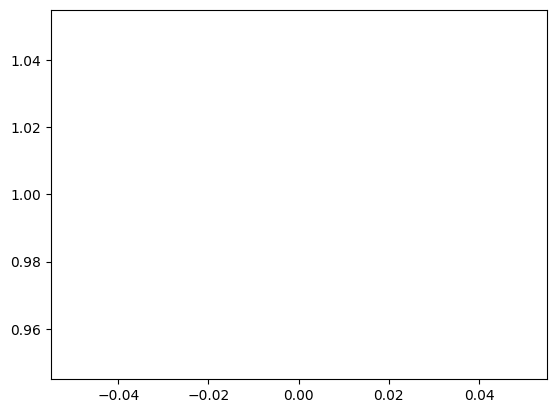

Q_values:
---Hit: 0.0
---Stand: -0.47853742236545127
Player:
---Hand: [10, 5]
---Max Value: 15
---Min Value: 15
Player Action: hit
Player:
---Hand: [10, 5, 7]
---Max Value: 22
---Min Value: 22
Player loses (Busts).
Rewards: -1

Episode: 2
Win rate: 0.5, Draw rate: 0.0


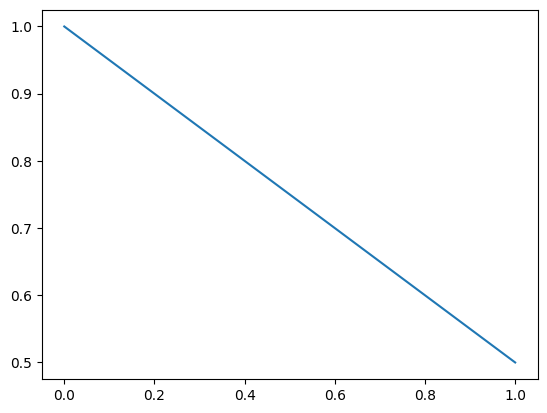

Q_values:
---Hit: 0.0
---Stand: -0.34875794802715304
Player:
---Hand: [5, 1]
---Max Value: 16
---Min Value: 6
Player Action: hit
Q_values:
---Hit: 6.28099779048509e-06
---Stand: -0.2147050765521854
Player:
---Hand: [5, 1, 9]
---Max Value: 25
---Min Value: 15
Player Action: hit
Q_values:
---Hit: 0.006459574793384487
---Stand: -0.10020335273274056
Player:
---Hand: [5, 1, 9, 4]
---Max Value: 29
---Min Value: 19
Player Action: hit
Player:
---Hand: [5, 1, 9, 4, 7]
---Max Value: 36
---Min Value: 26
Player loses (Busts).
Rewards: -1

Episode: 4
Win rate: 0.25, Draw rate: 0.0


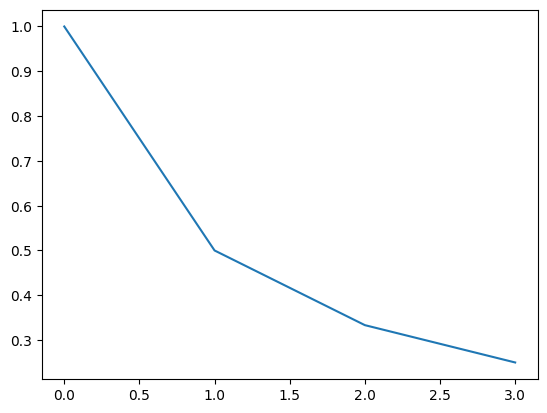

Q_values:
---Hit: 0.0
---Stand: 0.9560888186365475
Player:
---Hand: [9, 9]
---Max Value: 18
---Min Value: 18
Player Action: stand
Dealer:
---Hand: [11]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [11, 9]
---Max Value: 19
---Min Value: 19
Dealer Action: stand
Player loses (Worse Hand).
Rewards: -1

Episode: 8
Win rate: 0.375, Draw rate: 0.0


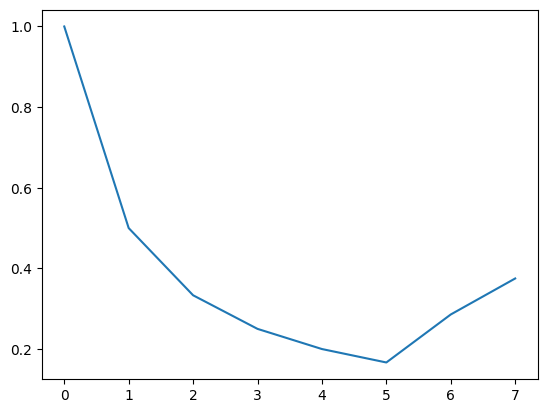

Q_values:
---Hit: 0.0
---Stand: 6.817835694098933
Player:
---Hand: [11, 11]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [2]
---Max Value: 2
---Min Value: 2
Dealer Action: hit
Dealer:
---Hand: [2, 5]
---Max Value: 7
---Min Value: 7
Dealer Action: hit
Dealer:
---Hand: [2, 5, 2]
---Max Value: 9
---Min Value: 9
Dealer Action: hit
Dealer:
---Hand: [2, 5, 2, 6]
---Max Value: 15
---Min Value: 15
Dealer Action: hit
Dealer:
---Hand: [2, 5, 2, 6, 2]
---Max Value: 17
---Min Value: 17
Dealer Action: stand
Player wins (Better Hand).
Rewards: +1

Episode: 16
Win rate: 0.4375, Draw rate: 0.125


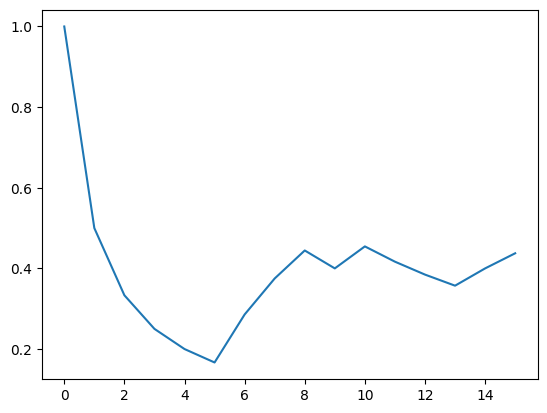

Player:
---Hand: [9, 9]
---Max Value: 18
---Min Value: 18
Player Action: hit
Player:
---Hand: [9, 9, 8]
---Max Value: 26
---Min Value: 26
Player loses (Busts).
Rewards: -1

Episode: 32
Win rate: 0.34375, Draw rate: 0.0625


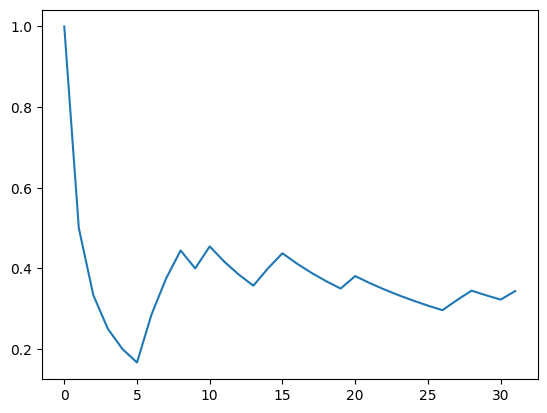

Q_values:
---Hit: 0.0
---Stand: -0.8468316404858429
Player:
---Hand: [9, 4]
---Max Value: 13
---Min Value: 13
Player Action: hit
Q_values:
---Hit: 6.245596352187645
---Stand: 6.877710886593871
Player:
---Hand: [9, 4, 7]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [9]
---Max Value: 9
---Min Value: 9
Dealer Action: hit
Dealer:
---Hand: [9, 12]
---Max Value: 19
---Min Value: 19
Dealer Action: stand
Player wins (Better Hand).
Rewards: +1

Episode: 64
Win rate: 0.421875, Draw rate: 0.046875


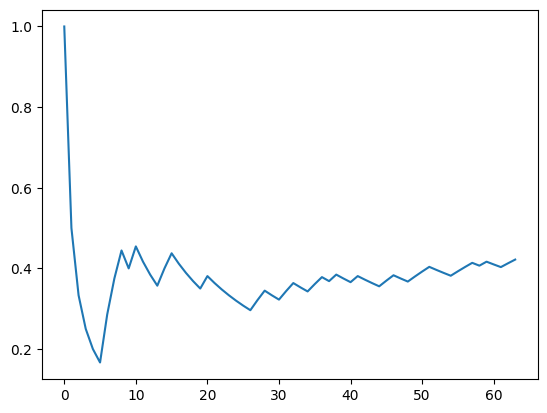

Q_values:
---Hit: 0.0
---Stand: -0.5531464413092809
Player:
---Hand: [12, 4]
---Max Value: 14
---Min Value: 14
Player Action: hit
Player:
---Hand: [12, 4, 12]
---Max Value: 24
---Min Value: 24
Player loses (Busts).
Rewards: -1

Episode: 128
Win rate: 0.390625, Draw rate: 0.0390625


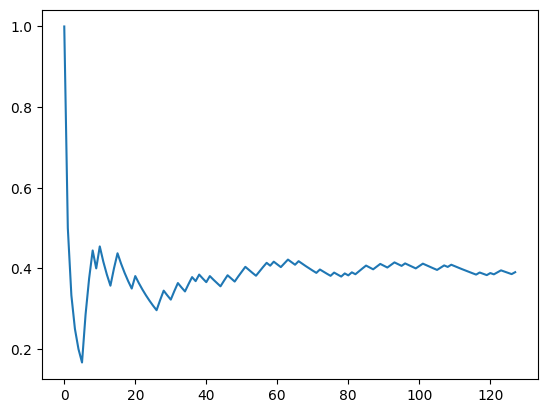

Q_values:
---Hit: 0.0
---Stand: -0.47853742236545127
Player:
---Hand: [10, 5]
---Max Value: 15
---Min Value: 15
Player Action: hit
Player:
---Hand: [10, 5, 11]
---Max Value: 25
---Min Value: 25
Player loses (Busts).
Rewards: -1

Episode: 256
Win rate: 0.38671875, Draw rate: 0.04296875


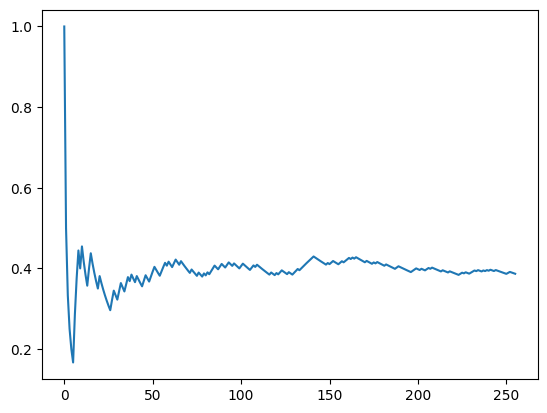

Q_values:
---Hit: 0.0
---Stand: -0.14994726599362526
Player:
---Hand: [1, 7]
---Max Value: 18
---Min Value: 8
Player Action: hit
Q_values:
---Hit: 0.0
---Stand: -0.20454465088735105
Player:
---Hand: [1, 7, 8]
---Max Value: 26
---Min Value: 16
Player Action: hit
Player:
---Hand: [1, 7, 8, 7]
---Max Value: 33
---Min Value: 23
Player loses (Busts).
Rewards: -1

Episode: 512
Win rate: 0.37890625, Draw rate: 0.048828125


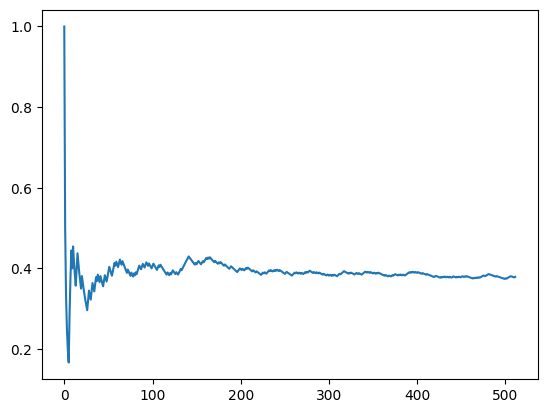

Player:
---Hand: [9, 4]
---Max Value: 13
---Min Value: 13
Player Action: hit
Q_values:
---Hit: 3.5827484981840435e-05
---Stand: -0.32645052557775833
Player:
---Hand: [9, 4, 3]
---Max Value: 16
---Min Value: 16
Player Action: hit
Player:
---Hand: [9, 4, 3, 8]
---Max Value: 24
---Min Value: 24
Player loses (Busts).
Rewards: -1

Episode: 1024
Win rate: 0.3798828125, Draw rate: 0.05859375


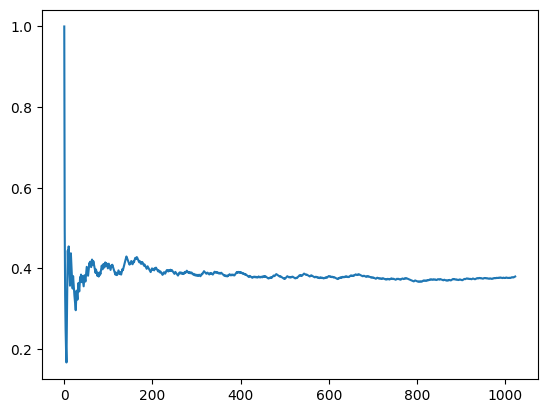

Q_values:
---Hit: 0.0
---Stand: -0.1665534232309034
Player:
---Hand: [7, 6]
---Max Value: 13
---Min Value: 13
Player Action: hit
Player:
---Hand: [7, 6, 10]
---Max Value: 23
---Min Value: 23
Player loses (Busts).
Rewards: -1

Episode: 2048
Win rate: 0.365234375, Draw rate: 0.064453125


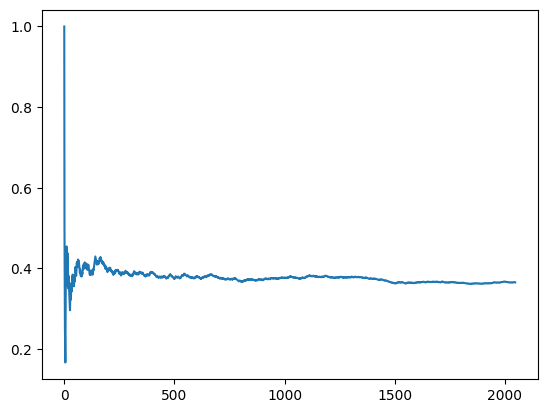

Player:
---Hand: [4, 1]
---Max Value: 15
---Min Value: 5
Player Action: hit
Q_values:
---Hit: 0.0
---Stand: -0.581958408138176
Player:
---Hand: [4, 1, 7]
---Max Value: 22
---Min Value: 12
Player Action: hit
Q_values:
---Hit: 0.0006020745827127134
---Stand: -0.172853855732238
Player:
---Hand: [4, 1, 7, 5]
---Max Value: 27
---Min Value: 17
Player Action: hit
Player:
---Hand: [4, 1, 7, 5, 11]
---Max Value: 37
---Min Value: 27
Player loses (Busts).
Rewards: -1

Episode: 4096
Win rate: 0.379638671875, Draw rate: 0.072509765625


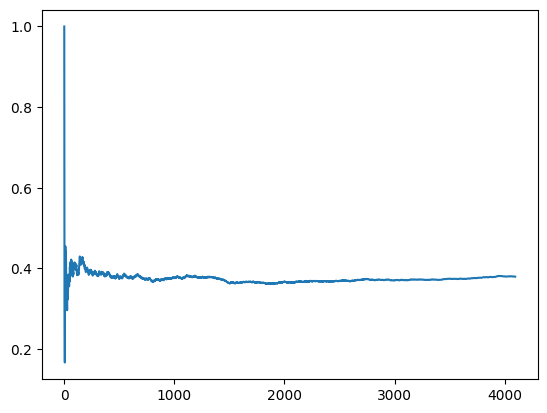

Q_values:
---Hit: 0.0
---Stand: 6.768297742354963
Player:
---Hand: [10, 11]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [4]
---Max Value: 4
---Min Value: 4
Dealer Action: hit
Dealer:
---Hand: [4, 1]
---Max Value: 15
---Min Value: 5
Dealer Action: hit
Dealer:
---Hand: [4, 1, 5]
---Max Value: 20
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [4, 1, 5, 1]
---Max Value: 21
---Min Value: 11
Dealer Action: hit
Dealer:
---Hand: [4, 1, 5, 1, 12]
---Max Value: 31
---Min Value: 21
Dealer Action: stand
Player loses (Worse Hand).
Rewards: -1

Episode: 8192
Win rate: 0.37353515625, Draw rate: 0.0709228515625


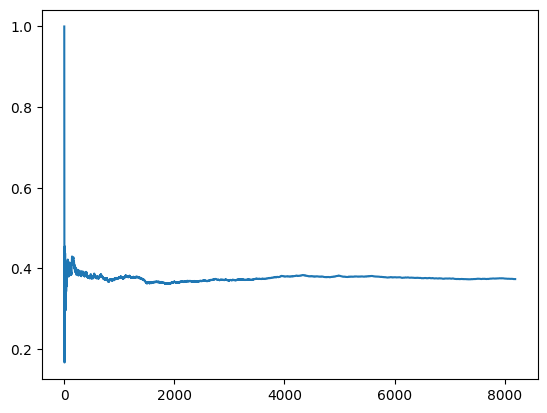

Player:
---Hand: [8, 3]
---Max Value: 11
---Min Value: 11
Player Action: hit
Q_values:
---Hit: 0.0010527698611043864
---Stand: -0.13584517902232926
Player:
---Hand: [8, 3, 4]
---Max Value: 15
---Min Value: 15
Player Action: hit
Player:
---Hand: [8, 3, 4, 8]
---Max Value: 23
---Min Value: 23
Player loses (Busts).
Rewards: -1

Win Rate: 0.3792, Draw Rate: 0.0691, Average reward over 10000 episodes: -0.15095


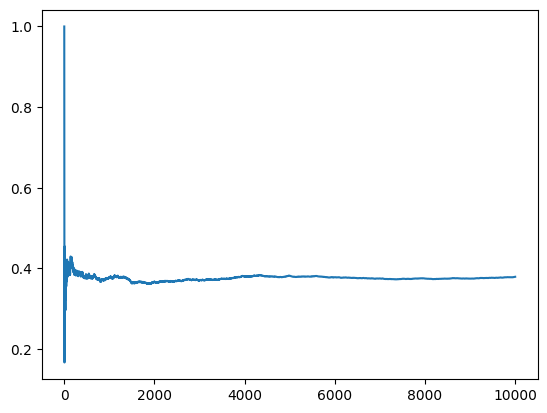

In [97]:
rewards1, avg_reward1, tracker1 = test(env=env, agent=agent1, verbose=True, num_episodes=10000)

## Visualize Player's Actions (Note That Action 22 = Player Busts)

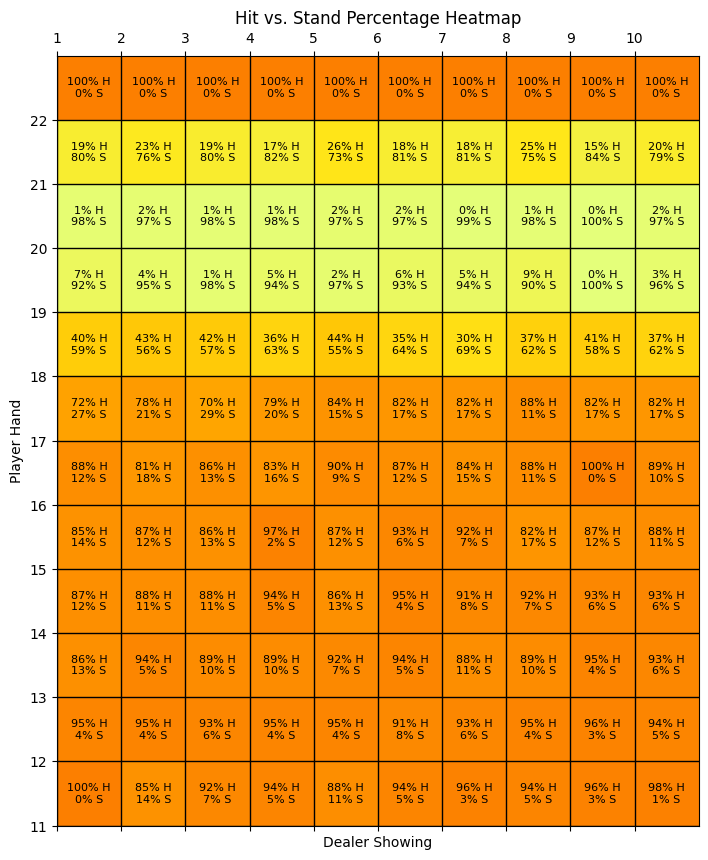

In [98]:
plot_policy(tracker1)

In [99]:
# Check the counts of the player's actions by card totals (Note: 22 = player busts)
get_action_cnt(tracker1)

Counter({(4, 'hit'): 97,
         (4, 'stand'): 3,
         (5, 'hit'): 113,
         (5, 'stand'): 6,
         (6, 'hit'): 202,
         (6, 'stand'): 13,
         (7, 'hit'): 290,
         (7, 'stand'): 19,
         (8, 'hit'): 359,
         (8, 'stand'): 19,
         (9, 'hit'): 456,
         (9, 'stand'): 28,
         (10, 'hit'): 525,
         (10, 'stand'): 37,
         (11, 'hit'): 662,
         (11, 'stand'): 35,
         (12, 'hit'): 963,
         (12, 'stand'): 54,
         (13, 'hit'): 925,
         (13, 'stand'): 85,
         (14, 'hit'): 874,
         (14, 'stand'): 80,
         (15, 'hit'): 799,
         (15, 'stand'): 97,
         (16, 'hit'): 737,
         (16, 'stand'): 98,
         (17, 'hit'): 656,
         (17, 'stand'): 159,
         (18, 'hit'): 388,
         (18, 'stand'): 616,
         (19, 'hit'): 61,
         (19, 'stand'): 1280,
         (20, 'hit'): 30,
         (20, 'stand'): 1733,
         (21, 'hit'): 276,
         (21, 'stand'): 1071,
         (22, 'hit'

# Q2: Method 2 - Monte Carlo Model

This class implements a Monte Carlo agent for playing Blackjack. The generate_episode method generates a single episode using the current policy. It simulates a Blackjack game, making decisions based on the agent's current policy. It returns a list of (state, action) tuples representing the episode and the total reward obtained in the episode. The agent explores by taking random actions with probability epsilon and exploits by choosing actions based on the Q-values.

The train method trains the agent by running multiple episodes and updating the Q-table. It iterates through the specified number of training episodes and, for each episode, generates an episode using the current policy. The method computes the return G for each state-action pair and uses a Monte Carlo update rule to update the Q-values. It prioritizes less frequently visited states to promote exploration.

The choose_action method selects the action for a given state based on the current Q-values. It determines whether to "hit" or "stand" based on the Q-values of the state-action pairs in the Q-table.

In [100]:
class MonteCarloAgent:
    """
    Initialize the Monte Carlo Agent.

    Args:
        env: The environment the agent interacts with.
        epsilon: The exploration-exploitation trade-off parameter.
        num_episodes: The number of episodes to run during training.
        verbose: If True, the agent will print episode information.
    """
    def __init__(self, env, epsilon=0.1, gamma=0.9, num_episodes=100000, verbose=False):
        self.env = env
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.Q = {}  # Q-table to store state-action values
        self.N = {}  # Keeps track of the number of visits to each state-action pair
        self.verbose = verbose
        self.gamma = gamma

    def generate_episode(self):
        """
        Generate a single episode using the current policy.

        Returns:
            episode: A list of (state, action) tuples representing the episode.
            reward: The total reward obtained in the episode.
        """
        episode = []
        player_hand, dealer_hand = self.env.initial_state()
        done = False

        while not done:
            state = tuple(player_hand)
            if state not in self.Q:
                self.Q[state] = {'hit': 0, 'stand': 0}  # If the satte is not available, initialize with 0

            if np.random.rand() < self.epsilon:  # Randomly choose an action
                action = np.random.choice(['hit', 'stand'])
            else:  # Choose an action based on the Q value of the state-action pair
                action = 'hit' if self.Q[state]['hit'] > self.Q[state]['stand'] else 'stand'

            episode.append((state, action))  # Save state-action pair into episode list
            player_hand, dealer_hand, reward, done = self.env.step(player_hand, dealer_hand, action)

        return episode, reward

    def train(self):
        """
        Train the agent by running multiple episodes and updating the Q-table.
        """
        for _ in range(self.num_episodes):
            episode, reward = self.generate_episode()
            G = 0
            for state, action in episode:
                G = self.gamma * G + reward
                if state not in self.N:
                    self.N[state] = {'hit': 0, 'stand': 0}  # If the satte is not available, initialize with 0
                self.N[state][action] += 1   # Increase the counter if episode already visited
                alpha = 1 / self.N[state][action]
                self.Q[state][action] += alpha* (G - self.Q[state][action])  # Update Q table by normalizing updates to prioritize less frequently visited states

    def choose_action(self, player_hand):
        """
        Choose the action for a given state based on the current Q-values.

        Args:
            player_hand: The current player's hand.

        Returns:
            action: The selected action ('hit' or 'stand').
        """
        state = tuple(player_hand)
        if state not in self.Q:
            self.Q[state] = {'hit': 0, 'stand': 0}
        return 'hit' if self.Q[state]['hit'] > self.Q[state]['stand'] else 'stand'

In [101]:
# Create the environment and agent
env = BlackjackEnvironment(verbose=True)
agent2 = MonteCarloAgent(env=env, epsilon=0.1, gamma=0.9, num_episodes=1000000, verbose=True)
# Train the agent
agent2.train()

Episode: 1
Win rate: 0.0, Draw rate: 0.0


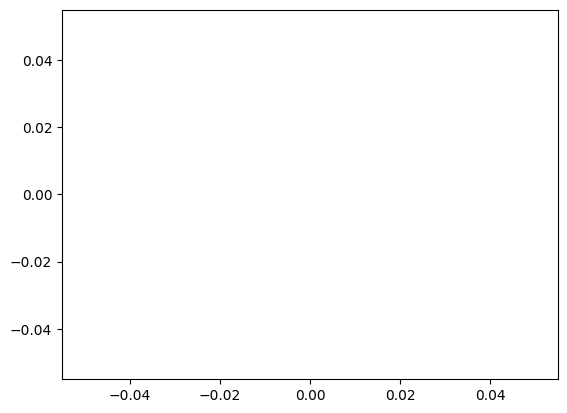

Player:
---Hand: [1, 7]
---Max Value: 18
---Min Value: 8
Player Action: stand
Dealer:
---Hand: [8]
---Max Value: 8
---Min Value: 8
Dealer Action: hit
Dealer:
---Hand: [8, 2]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [8, 2, 4]
---Max Value: 14
---Min Value: 14
Dealer Action: hit
Dealer:
---Hand: [8, 2, 4, 3]
---Max Value: 17
---Min Value: 17
Dealer Action: stand
Player wins (Better Hand).
Rewards: +1

Episode: 2
Win rate: 0.5, Draw rate: 0.0


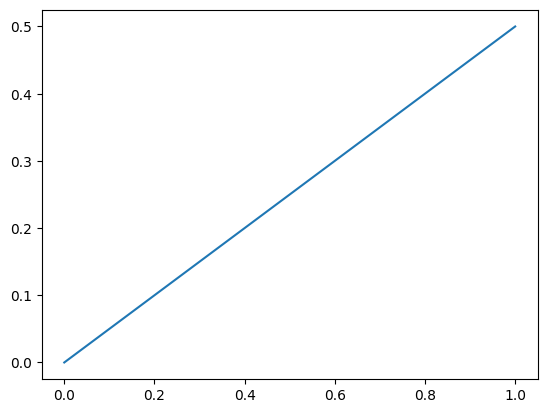

Player:
---Hand: [3, 10]
---Max Value: 13
---Min Value: 13
Player Action: hit
Player:
---Hand: [3, 10, 6]
---Max Value: 19
---Min Value: 19
Player Action: stand
Dealer:
---Hand: [3]
---Max Value: 3
---Min Value: 3
Dealer Action: hit
Dealer:
---Hand: [3, 10]
---Max Value: 13
---Min Value: 13
Dealer Action: hit
Dealer:
---Hand: [3, 10, 12]
---Max Value: 23
---Min Value: 23
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 4
Win rate: 0.5, Draw rate: 0.0


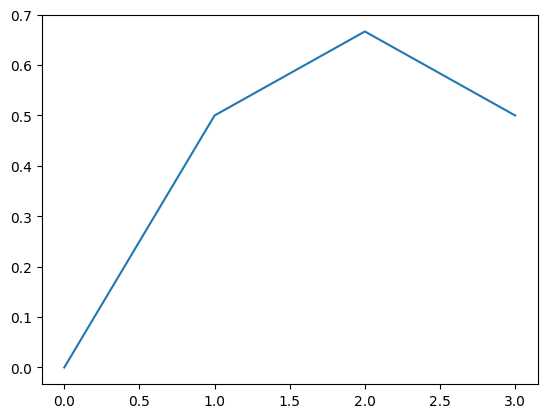

Player:
---Hand: [1, 12]
---Max Value: 21
---Min Value: 11
Player Action: stand
Player wins (BlackJack).
Rewards: +1.5

Episode: 8
Win rate: 0.375, Draw rate: 0.0


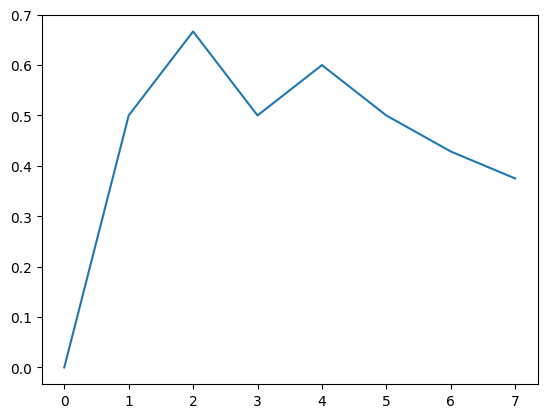

Player:
---Hand: [2, 3]
---Max Value: 5
---Min Value: 5
Player Action: stand
Dealer:
---Hand: [6]
---Max Value: 6
---Min Value: 6
Dealer Action: hit
Dealer:
---Hand: [6, 2]
---Max Value: 8
---Min Value: 8
Dealer Action: hit
Dealer:
---Hand: [6, 2, 2]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [6, 2, 2, 12]
---Max Value: 20
---Min Value: 20
Dealer Action: stand
Player loses (Worse Hand).
Rewards: -1

Episode: 16
Win rate: 0.3125, Draw rate: 0.0


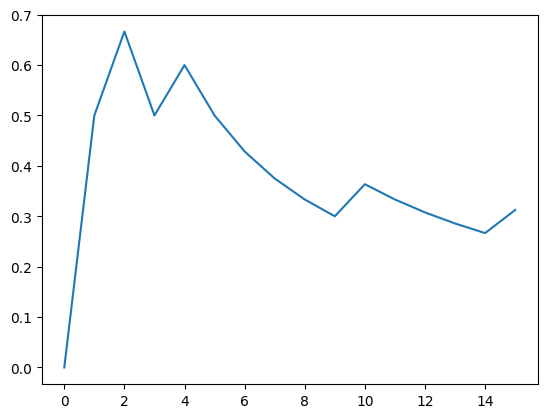

Player:
---Hand: [12, 10]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [7]
---Max Value: 7
---Min Value: 7
Dealer Action: hit
Dealer:
---Hand: [7, 2]
---Max Value: 9
---Min Value: 9
Dealer Action: hit
Dealer:
---Hand: [7, 2, 3]
---Max Value: 12
---Min Value: 12
Dealer Action: hit
Dealer:
---Hand: [7, 2, 3, 2]
---Max Value: 14
---Min Value: 14
Dealer Action: hit
Dealer:
---Hand: [7, 2, 3, 2, 3]
---Max Value: 17
---Min Value: 17
Dealer Action: stand
Player wins (Better Hand).
Rewards: +1

Episode: 32
Win rate: 0.375, Draw rate: 0.03125


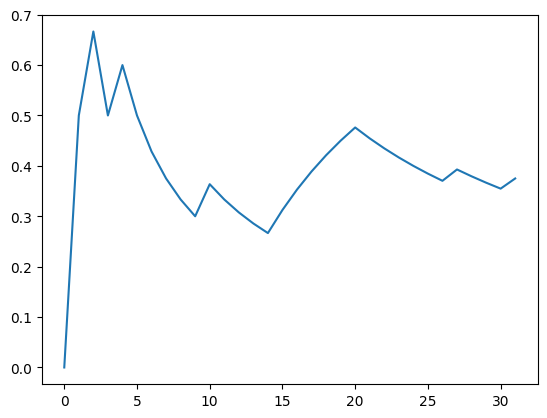

Player:
---Hand: [10, 12]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [12]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [12, 11]
---Max Value: 20
---Min Value: 20
Dealer Action: stand
Tie.
Rewards: 0

Episode: 64
Win rate: 0.421875, Draw rate: 0.078125


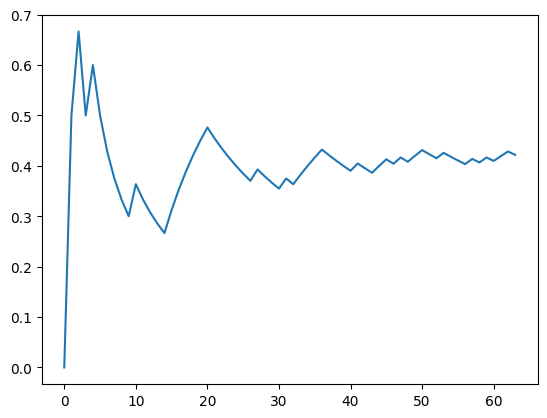

Player:
---Hand: [10, 10]
---Max Value: 20
---Min Value: 20
Player Action: stand
Dealer:
---Hand: [6]
---Max Value: 6
---Min Value: 6
Dealer Action: hit
Dealer:
---Hand: [6, 6]
---Max Value: 12
---Min Value: 12
Dealer Action: hit
Dealer:
---Hand: [6, 6, 2]
---Max Value: 14
---Min Value: 14
Dealer Action: hit
Dealer:
---Hand: [6, 6, 2, 12]
---Max Value: 24
---Min Value: 24
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 128
Win rate: 0.4375, Draw rate: 0.0859375


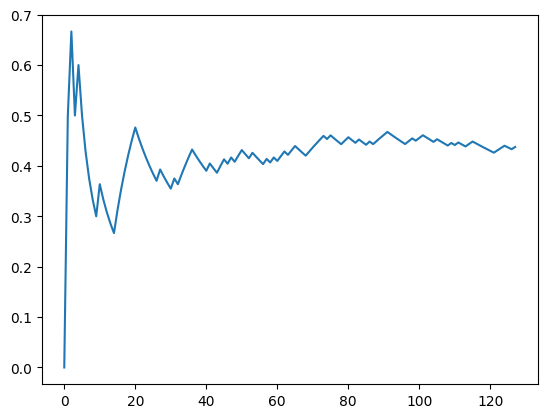

Player:
---Hand: [8, 9]
---Max Value: 17
---Min Value: 17
Player Action: stand
Dealer:
---Hand: [6]
---Max Value: 6
---Min Value: 6
Dealer Action: hit
Dealer:
---Hand: [6, 8]
---Max Value: 14
---Min Value: 14
Dealer Action: hit
Dealer:
---Hand: [6, 8, 1]
---Max Value: 15
---Min Value: 15
Dealer Action: hit
Dealer:
---Hand: [6, 8, 1, 10]
---Max Value: 25
---Min Value: 25
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 256
Win rate: 0.4296875, Draw rate: 0.08984375


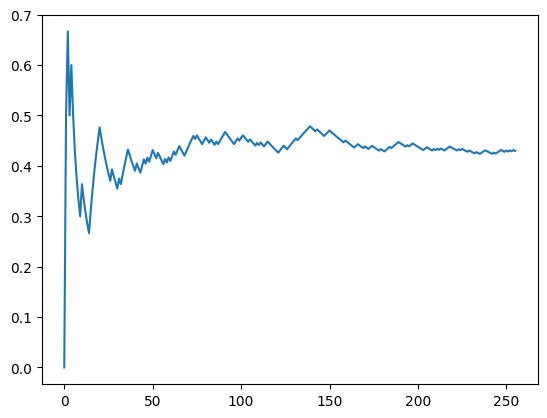

Player:
---Hand: [2, 3]
---Max Value: 5
---Min Value: 5
Player Action: stand
Dealer:
---Hand: [9]
---Max Value: 9
---Min Value: 9
Dealer Action: hit
Dealer:
---Hand: [9, 9]
---Max Value: 18
---Min Value: 18
Dealer Action: stand
Player loses (Worse Hand).
Rewards: -1

Episode: 512
Win rate: 0.41796875, Draw rate: 0.076171875


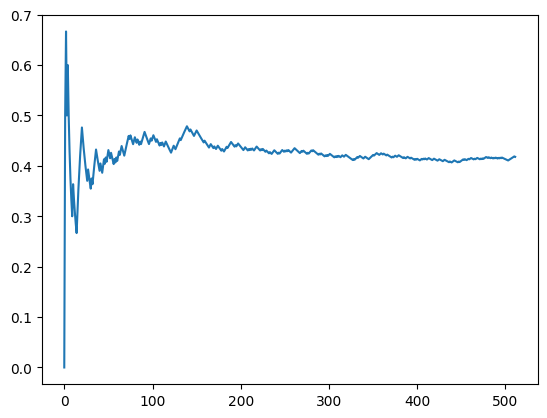

Player:
---Hand: [1, 3]
---Max Value: 14
---Min Value: 4
Player Action: hit
Player:
---Hand: [1, 3, 12]
---Max Value: 24
---Min Value: 14
Player Action: hit
Player:
---Hand: [1, 3, 12, 2]
---Max Value: 26
---Min Value: 16
Player Action: stand
Dealer:
---Hand: [10]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [10, 2]
---Max Value: 12
---Min Value: 12
Dealer Action: hit
Dealer:
---Hand: [10, 2, 4]
---Max Value: 16
---Min Value: 16
Dealer Action: hit
Dealer:
---Hand: [10, 2, 4, 11]
---Max Value: 26
---Min Value: 26
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 1024
Win rate: 0.43359375, Draw rate: 0.0791015625


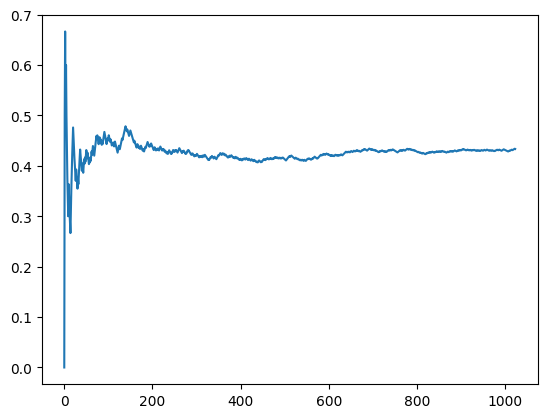

Player:
---Hand: [7, 9]
---Max Value: 16
---Min Value: 16
Player Action: stand
Dealer:
---Hand: [5]
---Max Value: 5
---Min Value: 5
Dealer Action: hit
Dealer:
---Hand: [5, 12]
---Max Value: 15
---Min Value: 15
Dealer Action: hit
Dealer:
---Hand: [5, 12, 7]
---Max Value: 22
---Min Value: 22
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 2048
Win rate: 0.45458984375, Draw rate: 0.0771484375


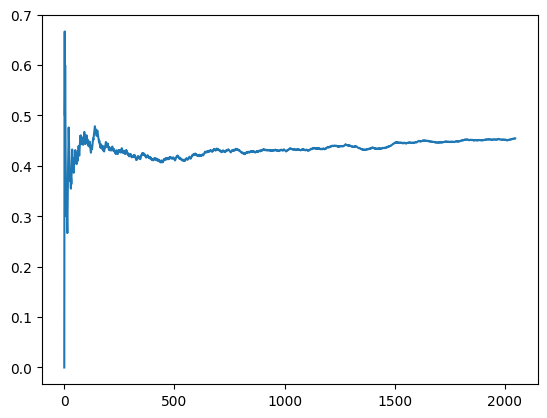

Player:
---Hand: [2, 10]
---Max Value: 12
---Min Value: 12
Player Action: hit
Player:
---Hand: [2, 10, 4]
---Max Value: 16
---Min Value: 16
Player Action: hit
Player:
---Hand: [2, 10, 4, 7]
---Max Value: 23
---Min Value: 23
Player loses (Busts).
Rewards: -1

Episode: 4096
Win rate: 0.447021484375, Draw rate: 0.08154296875


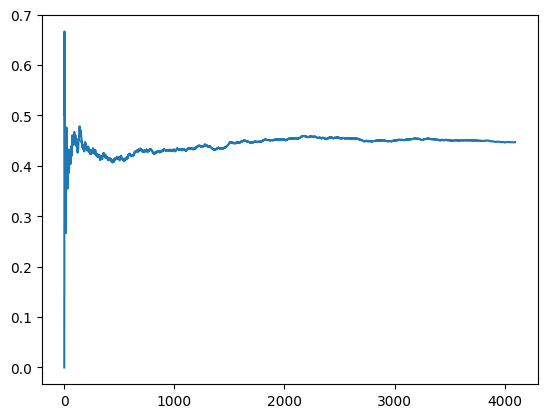

Player:
---Hand: [6, 1]
---Max Value: 17
---Min Value: 7
Player Action: hit
Player:
---Hand: [6, 1, 12]
---Max Value: 27
---Min Value: 17
Player Action: stand
Dealer:
---Hand: [12]
---Max Value: 10
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [12, 5]
---Max Value: 15
---Min Value: 15
Dealer Action: hit
Dealer:
---Hand: [12, 5, 7]
---Max Value: 22
---Min Value: 22
Dealer Action: stand
Player wins (Dealer Busts).
Rewards: +1

Episode: 8192
Win rate: 0.453857421875, Draw rate: 0.0767822265625


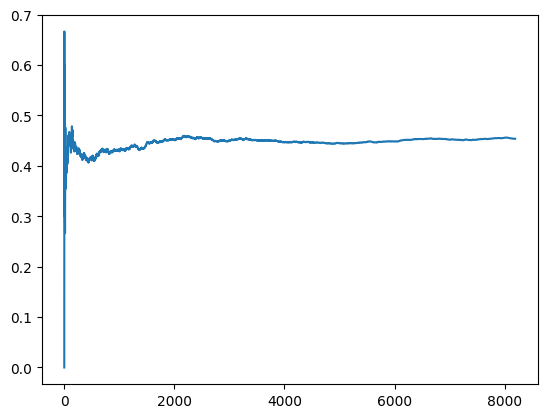

Player:
---Hand: [11, 8]
---Max Value: 18
---Min Value: 18
Player Action: stand
Dealer:
---Hand: [3]
---Max Value: 3
---Min Value: 3
Dealer Action: hit
Dealer:
---Hand: [3, 3]
---Max Value: 6
---Min Value: 6
Dealer Action: hit
Dealer:
---Hand: [3, 3, 2]
---Max Value: 8
---Min Value: 8
Dealer Action: hit
Dealer:
---Hand: [3, 3, 2, 1]
---Max Value: 19
---Min Value: 9
Dealer Action: hit
Dealer:
---Hand: [3, 3, 2, 1, 1]
---Max Value: 20
---Min Value: 10
Dealer Action: hit
Dealer:
---Hand: [3, 3, 2, 1, 1, 9]
---Max Value: 29
---Min Value: 19
Dealer Action: stand
Player loses (Worse Hand).
Rewards: -1

Win Rate: 0.4526, Draw Rate: 0.0772, Average reward over 10000 episodes: 0.00235


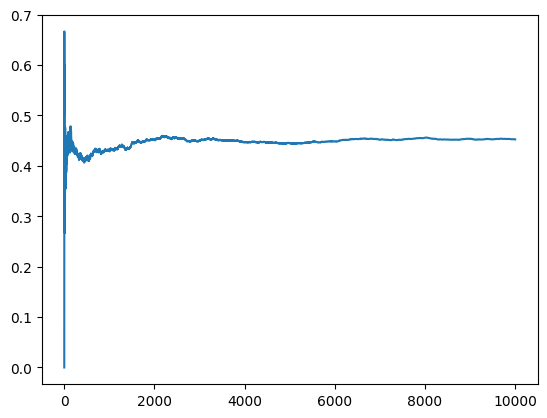

In [102]:
rewards2, avg_reward2, tracker2 = test(env=env, agent=agent2, verbose=True, num_episodes=10000)

## Visualize Player's Actions (Note That Action 22 = Player Busts)

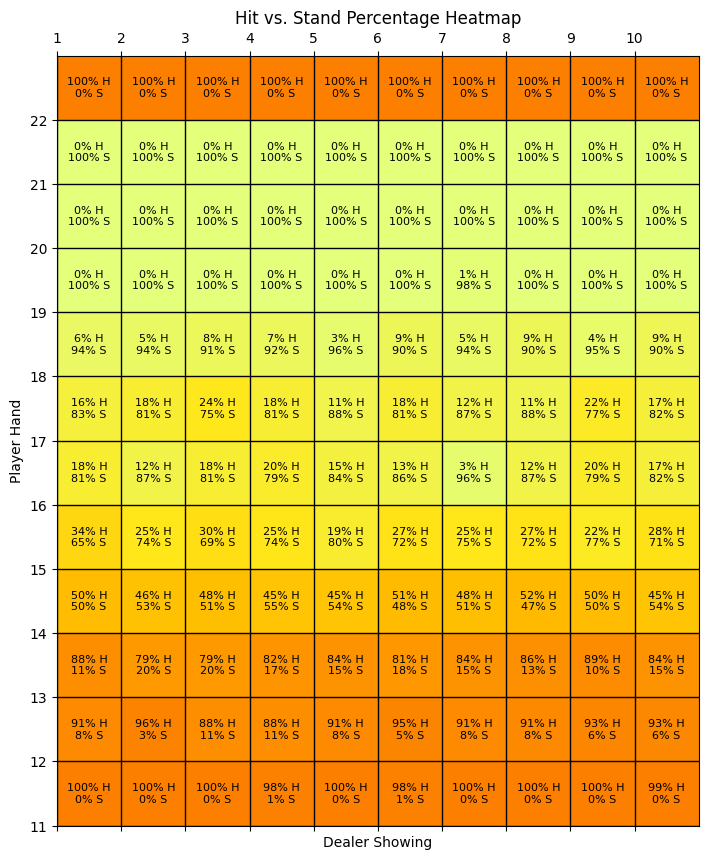

In [103]:
plot_policy(tracker2)

In [104]:
# Check the counts of the player's actions by card totals (Note: 22 = busts)
get_action_cnt(tracker2)

Counter({(4, 'hit'): 68,
         (5, 'hit'): 76,
         (5, 'stand'): 77,
         (6, 'hit'): 255,
         (7, 'hit'): 224,
         (7, 'stand'): 70,
         (8, 'hit'): 362,
         (9, 'hit'): 453,
         (10, 'hit'): 571,
         (10, 'stand'): 2,
         (11, 'hit'): 654,
         (11, 'stand'): 3,
         (12, 'hit'): 930,
         (12, 'stand'): 79,
         (13, 'hit'): 899,
         (13, 'stand'): 169,
         (14, 'hit'): 550,
         (14, 'stand'): 597,
         (15, 'hit'): 344,
         (15, 'stand'): 931,
         (16, 'hit'): 212,
         (16, 'stand'): 1129,
         (17, 'hit'): 236,
         (17, 'stand'): 1136,
         (18, 'hit'): 94,
         (18, 'stand'): 1185,
         (19, 'hit'): 1,
         (19, 'stand'): 1119,
         (20, 'stand'): 1327,
         (21, 'stand'): 998,
         (22, 'hit'): 1178})

### Comparing Agents' Bust Rate between Q Learning and Monte Carlo

In [105]:
# Q Learning
ql_bust_rate = dict(get_action_cnt(tracker1))[(22, 'hit')]/ sum(dict(get_action_cnt(tracker1)).values()) * 100

# Monte Carlo
mc_bust_rate = dict(get_action_cnt(tracker2))[(22, 'hit')]/ sum(dict(get_action_cnt(tracker2)).values()) * 100

print(f"Bust Rates:\nQ Learning: {ql_bust_rate} %\nMonte Carlo: {mc_bust_rate} %")

Bust Rates:
Q Learning: 23.684065479799372 %
Monte Carlo: 7.39531671793584 %


# Discussion

The results of the comparison between the Q-learning agent and the Monte Carlo agent in a Blackjack environment indicate significant differences in their playing strategies. The Q-learning agent is more aggressive, often choosing to hit for card totals below 19, while the Monte Carlo agent is more risk-averse and tends to stand at around a card total of 15.

Surprisingly, the Q-learning agent exhibits a lower winning rate (38%) and an average total reward of -0.15, whereas the Monte Carlo agent achieves a higher winning rate (45%) and an average total reward of 0.002. This difference may be attributed to the Q-learning agent's aggressive playstyle, resulting in a higher bust rate (24%) compared to the Monte Carlo agent's bust rate of 7%.

It's worth noting that the expected odds of winning for a player in a typical game of Blackjack are around 42%, and the Monte Carlo agent's results align more closely with this expectation. To further improve results, considerations include implementing advanced strategies such as doubling down and splitting pairs, incorporating card counting, fine-tuning hyperparameters, and experimenting with different reward structures.

